In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import glob as g
import scipy as sc

# Importation des donneés

In [3]:
def importer(dossier):
    
    liste_ext = {'xlsx':'excel','csv':'csv'}
    globals()['list_df'] = []
    
    fichiers = [file for file in g.glob(dossier+'/*')]
    
    for fichier in fichiers:

        fichier = fichier.split('\\')
        (fnom,fext) = fichier[len(fichier)-1].split('.')
        fichier = str(dossier)+'/'+str(fichier[1])
        
        if fext in liste_ext.keys():
            exec("globals()[fnom] = pd.read_"+liste_ext[fext]+"(fichier)")
            print(fichier + ": Importé dans '"+fnom+"'")
            list_df.append(fnom)
        else:
            print('extension non reconnu, liste compatible: ')
            print(liste_ext)
#findef

importer('./Data')

C:\ProgramData\Anaconda\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\ProgramData\Anaconda\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


./Data/erp.xlsx: Importé dans 'erp'
./Data/liaison.xlsx: Importé dans 'liaison'
./Data/web.xlsx: Importé dans 'web'


C:\ProgramData\Anaconda\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


# Compte des IDs

In [4]:
nb_id_web = len(pd.unique(web['sku']))
nb_id_erp = len(pd.unique(erp['product_id']))

display(str(nb_id_web) + ' id distinct dans le fichier web')
display(str(nb_id_erp) + ' id distinct dans le fichier erp')

'715 id distinct dans le fichier web'

'825 id distinct dans le fichier erp'

# Nettoyage Formatage et Fusion

In [5]:
#ID CASE VIDE

err_na = web[web['sku'].isnull()] #détection des cases vides
err_na = err_na.loc[:,['sku','post_name','post_date','post_type']]
web = web[web['sku'].notnull()] #on ne garde que les lignes possédant un 'sku'

#FORMAT DES ID

web['sku'] = web['sku'].astype({'sku':'string'}) #conversion du type 'objet' vers 'chaine'
err_id = web[~web['sku'].apply(lambda x: x.isnumeric())] #la conversion nous permet maintenant de détecter les ID non numérique
err_id = err_id.loc[:,['sku','post_name','post_date','post_type']]

#LIGNE DES IMAGES EN PIECE JOINTE

web['post_type'] = web['post_type'].astype({'post_type':'string'}) #conversion du type 'objet' vers 'chaine'
err_attach = web[web['post_type'] != 'product'] #La conversion nous permet de faire une comparaison
err_attach = err_attach.loc[:,['sku','post_name','post_date','post_type']]
web = web[web['post_type'] == 'product'] #on ne garde que les produits afin d'enlever les 'sku' en double

# Selection des colonnes utiles à l'analyse
erp = erp.loc[:,['product_id', 'price']]
web = web.loc[:,['sku','total_sales','post_name','post_date']]

# Renommage comme indiqué dans le mail
liaison = liaison.rename(columns={'id_web':'sku'})
liaison['sku'] = liaison['sku'].astype({'sku':'string'})

# MERGE
web_erp = erp.merge(liaison,how='outer', on='product_id')
web_erp = web.merge(web_erp,how='outer', on='sku',indicator=True)

# ERREUR DANS LE FICHIER 'LIAISON'
err_liaison = web_erp[web_erp['_merge'] != 'both']
    
web_erp = web_erp[web_erp['_merge'] == 'both']
web_erp = web_erp.loc[:,['product_id','sku','total_sales','price','post_name','post_date']]

# Erreurs dans le fichier web

### Les id vides

In [6]:
display(err_na.sort_values(by='post_name', ascending=True))

,sku,post_name,post_date,post_type
471,NaN,pierre-jean-villa-condrieu-suspendu-2018,2018-08-08 11:23:43,product
470,NaN,pierre-jean-villa-cote-rotie-fongeant-2017,2018-07-31 12:07:23,product
178,NaN,NaN,NaT,NaN
179,NaN,NaN,NaT,NaN
227,NaN,NaN,NaT,NaN
...,...,...,...,...
792,NaN,NaN,NaT,NaN
793,NaN,NaN,NaT,NaN
794,NaN,NaN,NaT,NaN
795,NaN,NaN,NaT,NaN


### Les id non numériques

In [7]:
display(err_id)

,sku,post_name,post_date,post_type
0,bon-cadeau-25-euros,bon-cadeau-de-25-euros,2018-06-01 13:53:46,product
797,13127-1,clos-du-mont-olivet-chateauneuf-du-pape-2007-2,2020-06-09 15:42:04,product
1209,bon-cadeau-25-euros,bon-cadeau-de-25-euros,2018-06-01 13:53:46,attachment
1511,13127-1,clos-du-mont-olivet-chateauneuf-du-pape-2007-2,2020-06-09 15:42:04,attachment


### Les id en doublons

In [8]:
display(err_attach)

,sku,post_name,post_date,post_type
799,15298,pierre-jean-villa-saint-joseph-preface-2018,2018-02-08 12:58:52,attachment
800,15296,pierre-jean-villa-saint-joseph-tilde-2017,2018-02-08 13:49:41,attachment
801,15300,pierre-jean-villa-croze-hermitage-accroche-coe...,2018-02-08 14:08:36,attachment
802,19814,pierre-jean-villa-igp-gamine-2018,2018-02-09 14:01:05,attachment
803,19815,pierre-jean-villa-cote-rotie-carmina-2017,2018-02-12 09:04:37,attachment
...,...,...,...,...
1508,16135,mouthes-le-bihan-aime-chai-2015,2020-04-25 13:22:38,attachment
1509,15891,camin-larredya-jurancon-sec-la-virada-2018,2020-05-02 14:53:40,attachment
1510,15887,jamet-cote-rotie-fructus-voluptas-2018,2020-05-02 15:00:54,attachment
1511,13127-1,clos-du-mont-olivet-chateauneuf-du-pape-2007-2,2020-06-09 15:42:04,attachment


# Erreur dans le fichier liaison

In [25]:
print("nombre d'id présent dans liaison mais pas dans web: " + str(err_liaison['sku'].count()))
print("nobmre de produit qui ont disparut du site web: " + str(len(err_liaison) ))
print("nombre de produit jamais mis en ligne: " + str(len(err_liaison) - (len(err_na) + err_liaison['sku'].count()) ))

with pd.option_context('display.max_rows', None, 'display.max_columns', None):    
    display(err_liaison.tail(21))

nombre d'id présent dans liaison mais pas dans web: 20
nobmre de produit qui ont disparut du site web: 111
nombre de produit jamais mis en ligne: 6


,sku,total_sales,post_name,post_date,product_id,price,_merge
804,<NA>,NaN,NaN,NaT,7204,45.0,right_only
805,13771,NaN,NaN,NaT,4289,22.8,right_only
806,15065,NaN,NaN,NaT,4568,21.5,right_only
807,14785,NaN,NaN,NaT,4584,32.3,right_only
808,12601,NaN,NaN,NaT,4741,12.4,right_only
809,15154,NaN,NaN,NaT,4864,8.3,right_only
810,14360,NaN,NaN,NaT,4869,17.2,right_only
811,15608,NaN,NaN,NaT,4921,13.8,right_only
812,15586,NaN,NaN,NaT,4922,21.5,right_only
813,15272,NaN,NaN,NaT,5018,15.4,right_only


# Tableau final

In [10]:
display(web_erp.sort_values(by='product_id', ascending=True))

,product_id,sku,total_sales,price,post_name,post_date
1,3847,15298,6.0,24.2,pierre-jean-villa-saint-joseph-preface-2018,2018-02-08 12:58:52
2,3849,15296,0.0,34.3,pierre-jean-villa-saint-joseph-tilde-2017,2018-02-08 13:49:41
3,3850,15300,0.0,20.8,pierre-jean-villa-croze-hermitage-accroche-coe...,2018-02-08 14:08:36
4,4032,19814,3.0,14.1,pierre-jean-villa-igp-gamine-2018,2018-02-09 14:01:05
5,4039,19815,0.0,46.0,pierre-jean-villa-cote-rotie-carmina-2017,2018-02-12 09:04:37
...,...,...,...,...,...,...
709,6930,16135,5.0,8.4,mouthes-le-bihan-aime-chai-2015,2020-04-25 13:22:38
710,7023,15891,0.0,27.5,camin-larredya-jurancon-sec-la-virada-2018,2020-05-02 14:53:40
711,7025,15887,0.0,69.0,jamet-cote-rotie-fructus-voluptas-2018,2020-05-02 15:00:54
712,7247,13127-1,0.0,54.8,clos-du-mont-olivet-chateauneuf-du-pape-2007-2,2020-06-09 15:42:04


# Ajout du chiffre d'affaire

In [11]:
web_erp.insert(0,"CA", (web_erp['total_sales']*web_erp['price']))

In [12]:
print("Chiffre d'affaire totale: " + str(web_erp['CA'].sum()) + "€")
display(web_erp.sort_values(by='post_date', ascending=True))

Chiffre d'affaire totale: 70568.6€


,CA,product_id,sku,total_sales,price,post_name,post_date
1,145.2,3847,15298,6.0,24.2,pierre-jean-villa-saint-joseph-preface-2018,2018-02-08 12:58:52
2,0.0,3849,15296,0.0,34.3,pierre-jean-villa-saint-joseph-tilde-2017,2018-02-08 13:49:41
3,0.0,3850,15300,0.0,20.8,pierre-jean-villa-croze-hermitage-accroche-coe...,2018-02-08 14:08:36
4,42.3,4032,19814,3.0,14.1,pierre-jean-villa-igp-gamine-2018,2018-02-09 14:01:05
5,0.0,4039,19815,0.0,46.0,pierre-jean-villa-cote-rotie-carmina-2017,2018-02-12 09:04:37
...,...,...,...,...,...,...,...
709,42.0,6930,16135,5.0,8.4,mouthes-le-bihan-aime-chai-2015,2020-04-25 13:22:38
710,0.0,7023,15891,0.0,27.5,camin-larredya-jurancon-sec-la-virada-2018,2020-05-02 14:53:40
711,0.0,7025,15887,0.0,69.0,jamet-cote-rotie-fructus-voluptas-2018,2020-05-02 15:00:54
712,0.0,7247,13127-1,0.0,54.8,clos-du-mont-olivet-chateauneuf-du-pape-2007-2,2020-06-09 15:42:04


# Quelques graphique pour y voir plus claire

q1=14 iqr=28 q3=42
uif=-70 lif=-28 médiane=23 lof=84 uof=126


C:\ProgramData\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

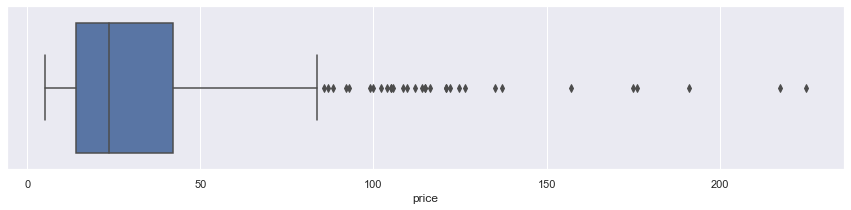

In [13]:
# interquartile
q1 = web_erp['price'].quantile(q=0.25)
q2 = web_erp['price'].quantile(q=0.50)
q3 = web_erp['price'].quantile(q=0.75)

iqr = q3-q1

uif = q1-3*iqr
lif = q1-1.5*iqr
lof = q3+1.5*iqr
uof = q3+3*iqr

print("q1="+str(int(q1)),"iqr="+str(int(iqr)),"q3="+str(int(q3)))
print("uif="+str(int(uif)),"lif="+str(int(lif)),"médiane="+str(int(q2)),"lof="+str(int(lof)),"uof="+str(int(uof)))

sns.set(rc = {'figure.figsize':(15,3)})
sns.boxplot(web_erp.price)

# Recherche des prix très au dessus de la moyenne

In [14]:
web_erp.insert(0,"Zscore", (sc.stats.zscore(web_erp.price)))

In [15]:
display(web_erp[web_erp['Zscore'] >= 2].sort_values(by='price', ascending=True))

,Zscore,CA,product_id,sku,total_sales,price,post_name,post_date
66,2.011686,0.0,4132,11668,0.0,88.4,zind-humbrecht-pinot-gris-grand-cru-rangen-de-...,2018-02-13 11:43:55
502,2.141225,0.0,5565,19822,0.0,92.0,tempier-bandol-cabassaou-2017,2018-11-26 10:59:10
602,2.177207,0.0,5916,14774,0.0,93.0,wemyss-malts-single-cask-chocolate-moka-cake,2019-04-04 16:39:24
655,2.393104,0.0,6214,11601,0.0,99.0,domaine-des-comtes-lafon-volnay-1er-cru-champa...,2019-07-25 09:15:41
64,2.429087,0.0,4115,15382,0.0,100.0,zind-humbrecht-riesling-gc-rangen-thann-clos-s...,2018-02-13 11:08:45
381,2.511848,0.0,4903,14805,0.0,102.3,domaine-des-croix-corton-grand-cru-les-greves-...,2018-05-15 10:10:57
223,2.573018,104.0,4407,3509,1.0,104.0,cognac-frapin-cigar-blend,2018-03-22 11:49:53
432,2.609001,0.0,5008,11602,0.0,105.0,domaine-des-comtes-lafon-volnay-1er-cru-santen...,2018-07-17 10:52:41
431,2.609001,0.0,5007,12791,0.0,105.0,domaine-des-comtes-lafon-volnay-1er-cru-santen...,2018-07-17 10:36:03
647,2.630591,0.0,6201,14596,0.0,105.6,david-duband-chambolle-musigny-1er-cru-les-sen...,2019-07-23 10:37:14


In [16]:
display(web_erp[web_erp['Zscore'] <= -0.95].sort_values(by='price', ascending=True))

,Zscore,CA,product_id,sku,total_sales,price,post_name,post_date
645,-0.982084,0.0,6129,14570,0.0,5.2,moulin-de-gassac-igp-pays-dherault-guilhem-bla...,2019-06-28 18:01:06
98,-0.964093,245.1,4172,16210,43.0,5.7,maurel-pays-oc-chardonnay-2019,2018-02-14 16:54:33
99,-0.964093,74.1,4173,16211,13.0,5.7,maurel-pays-doc-chenin-colombard-2019,2018-02-14 17:10:39
100,-0.964093,34.2,4174,16209,6.0,5.7,maurel-cabardes-tradition-2017,2018-02-14 17:15:31
560,-0.964093,0.0,5777,14338,0.0,5.7,maurel-pays-d-oc-cabernet-sauvignon-2017,2019-03-15 10:13:30
119,-0.960494,0.0,4198,16322,0.0,5.8,moulin-gassac-igp-pays-herault-guilhem-rouge-2019,2018-02-15 13:51:32
120,-0.960494,266.8,4200,16295,46.0,5.8,moulin-de-gassac-igp-pays-dherault-guilhem-ros...,2018-02-15 14:05:06
561,-0.960494,139.2,5778,15561,24.0,5.8,maurel-pays-d-oc-merot-2018,2019-03-15 10:20:59
562,-0.960494,46.4,5779,16213,8.0,5.8,maurel-pays-d-oc-syrah-2019,2019-03-15 10:24:21


# Visuel sur les prix en fonction des ventes

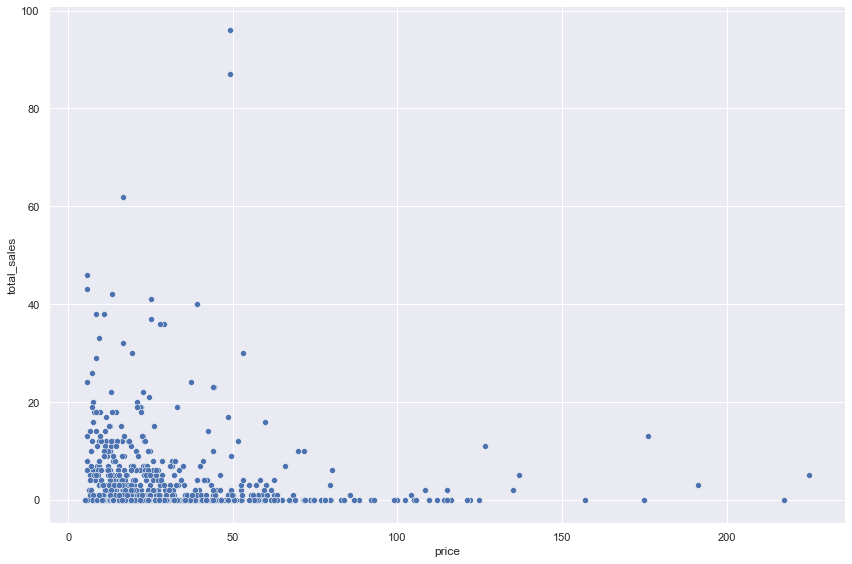

In [17]:
sns.relplot(x=web_erp['price'], y=web_erp.total_sales, height=8, aspect=1.5)

# Visuel sur les prix en fonction du Chiffre d'affaire

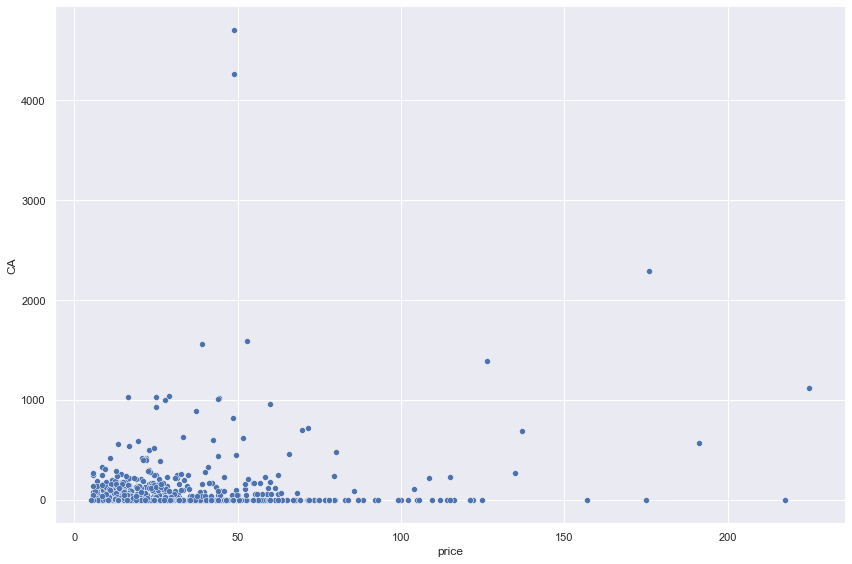

In [18]:
sns.set(rc = {'figure.figsize':(15,9)})
sns.relplot(x=web_erp['price'], y=web_erp['CA'], height=8, aspect=1.5)

In [19]:
# titre

<AxesSubplot:xlabel='post_date', ylabel='total_sales'>

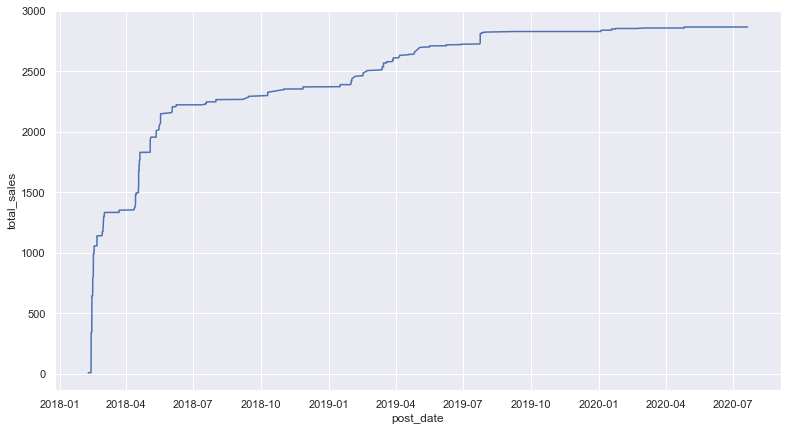

In [20]:
vente_cumul = web_erp.sort_values(by='post_date', ascending=True).total_sales.cumsum()

sns.set(rc = {'figure.figsize':(13,7)})
sns.lineplot(x=web_erp.post_date, y=vente_cumul)